In [375]:
# notebook

# print full np arrays
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

# import libraries

import rasterio
import rasterio.plot
from rasterio.crs import CRS
from matplotlib import pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm import tqdm
import rasterio.mask
from shapely.geometry import Point
from geopandas import GeoDataFrame
import matplotlib.colors as colors
from matplotlib import cm
from shapely.geometry import Polygon
from rasterio.transform import from_gcps
from rasterio.control import GroundControlPoint as GCP

plt.rcParams.update({'font.size': 20})
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [376]:
# set vars here!

here = "/home/till/projects"
region = "europe"
map_path = f"{here}/heatchmap/map/map_{region}.tif"

ROADS = False
CITIES = False
CIRCLE = 50000
WAIT_MAX = 24 * 60
# resolution 40 for world -> 6800x14400 image -> lets calculating distribution crash -> too many values in np array to calculate?
RESOLUTION = 10
THRESHOLD = 0.00000001 # quite arbitrary
RECOMPUTE = True

# adjust stdv of single points
K = 1
FACTOR_STDV = 1 # the xth stdv


In [377]:

def get_points(path):
    points = gpd.read_file(path)
    points.wait = points.wait.astype(float)
    points.lat = points.lat.astype(float)
    points.lon = points.lon.astype(float)
    # threshold - assuming that values above that are skewed due to angriness of the hiker
    points = points[points['wait'] <= WAIT_MAX]

    # use epsg 3857 as default as it gives coordinates in meters
    points.geometry = gpd.points_from_xy(points.lon, points.lat)
    points.crs = CRS.from_epsg(4326)
    points = points.to_crs(epsg=3857)

    return points
    
# read from the hitchmap dump
points = get_points(f"{here}/heatchmap/waiting_time_per_point.csv")

all_points = points

# to get the same example as here https://abelblogja.wordpress.com/average-waiting-times-in-europe/
artificial_points = get_points(f"{here}/heatchmap/artificial_points.csv")

In [378]:
def get_points_in_region(points, region):
        # set lat long boundaries of different scopes of the map

        maps = {
                "germany": [5.0, 48.0, 15.0, 55.0],
                "europe": [-12.0, 35.0, 45.0, 71.0],
                "world": [-180.0, -85.0, 180.0, 85.0], # 85 lat bc of 3857
                "small": [12.0, 52.0, 15.0, 54.0],
                "africa": [-20.0, -35.0, 60.0, 40.0],
                "asia": [40.0, 0.0, 180.0, 85.0],
                "north_america": [-180.0, 0.0, -20.0, 85.0],
                "south_america": [-90.0, -60.0, -30.0, 15.0],
                "australia": [100.0, -50.0, 180.0, 0.0],
                "middle_africa": [-10.0, -35.0, 60.0, 20.0],
                "artificial": [8.0, -10.0, 30.0, 10.0],
                "greenland": [-80.0, 60.0, -10.0, 85.0],
                }
        map = maps[region]

        # create boundary polygon
        polygon = Polygon([(map[0], map[1]), (map[0], map[3]), (map[2], map[3]), (map[2], map[1]), (map[0], map[1])])
        polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon])  
        polygon = polygon.to_crs(epsg=3857)

        # extract points within polygon
        points = points[points.geometry.within(polygon.geometry[0])]

        return points, polygon, map

points, polygon, map = get_points_in_region(points, region)
if region == "artificial": 
        points = artificial_points
        print("artificial points")

In [379]:
# # test our normal distribution formula

# a = 5.0
# res = int(a * 2 * 100)
# x = np.linspace(-a, a, res)
# # mind starting with upper value of y axis here
# y = np.linspace(-a, a, res)
# X, Y = np.meshgrid(x, y)

# stdv = 0.5
# fwhm = 2.355 * stdv

# dist = np.exp(-4 * np.log(2) * ((X - 0.0) ** 2 + (Y - 0.0) ** 2) / fwhm**2)


# hf = plt.figure()
# ha = hf.add_subplot(111, projection='3d')

# X, Y = numpy.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
# ha.plot_surface(X, Y, dist)

# plt.show()

# plt.plot(dist[int(res / 2)])

In [380]:
# # example for 2 spots with distance "m" m from each other
# # verifying that where they meet the edge is as hard as seen in the plots

# sigma = 50000
# mu = 0

# fwhm = 2.355 * sigma

# # gives the distribution in the whole raster space as X and Y are used here
# def n(x):
#     return np.exp(-4 * np.log(2) * ((x - mu) ** 2 + (0 - mu) ** 2) / fwhm**2)

# a = []
# m = 100000

# a = [(n(i) * 45 + n(m-i) * 5) / (n(i) + n(m-i)) for i in range(0, m, 10000)]
# plt.plot(a)


In [381]:
def calc_radius(point, other_points, k=5):
    k = k + 1 # +1 as the point itself is also in the array
    distances = point.distance(other_points).to_numpy()
    idx = np.argpartition(distances, k)
    closest_distances = distances[idx[:k]]
    radius = np.ceil(max(closest_distances)) / FACTOR_STDV
    if radius > CIRCLE: print(point, radius)
    return radius

In [382]:
def make_raster_map(points, polygon, map):
    
    # https://stackoverflow.com/questions/7687679/how-to-generate-2d-gaussian-with-python
    def makeGaussian(stdv, x0, y0):
        """Make a square gaussian kernel.
        size is the length of a side of the square
        fwhm is full-width-half-maximum, which
        can be thought of as an effective radius.
        """
        # https://en.wikipedia.org/wiki/Full_width_at_half_maximum
        # TODO why fwhm used here?
        fwhm = 2.355 * stdv

        # gives the distribution in the whole raster space as X and Y are used here
        # TODO only calculate for pixels that will be colored (landmass) in the end
        # TODO only calculate for pixels that are significantly close to the point (e.g. 500 km around the point)
        return np.exp(-4 * np.log(2) * ((X - x0) ** 2 + (Y - y0) ** 2) / fwhm**2)
    
    def get_distribution(lat, lon):
        # standard deviation in meters -> 50 km around each spot; quite arbitrary
        STDV_M = max(CIRCLE, calc_radius(Point(lon, lat), points.geometry, k=K))
        return makeGaussian(STDV_M, lon, lat)    

    # create pixel grid for map

    xx, yy = polygon.geometry[0].exterior.coords.xy

    # Note above return values are of type `array.array` 
    xx = xx.tolist()
    yy = yy.tolist()

    # set resulution here
    resoltions_factor = RESOLUTION

    degree_width = int(map[2] - map[0])
    degree_height = int(map[3] - map[1])
    pixel_width = degree_width * resoltions_factor
    pixel_height = degree_height * resoltions_factor
    x = np.linspace(xx[0], xx[2], pixel_width)
    # mind starting with upper value of y axis here
    y = np.linspace(yy[2], yy[0], pixel_height)
    X, Y = np.meshgrid(x, y)
    X = np.longdouble(X)
    Y = np.longdouble(Y)

    print(X.shape, Y.shape)

    # sum of distributions
    Zn = None
    # weighted sum of distributions
    Zn_weighted = None

    try:
        if not RECOMPUTE:
            Z = np.loadtxt(f'{here}/heatchmap/map/map_{region}.txt', dtype=float)
        else:
            raise Exception("recompute")
    except:
        # create a raster map - resulution is defined above
        # https://stackoverflow.com/questions/56677267/tqdm-extract-time-passed-time-remaining
        with tqdm(zip(points.geometry.y, points.geometry.x, points.wait), total=len(points)) as t:
            # TODO find out how to speed up and parallelize this
            for lat, lon, wait in t:
                # distribution inserted by a single point
                Zi = get_distribution(lat, lon)
                # add the new distribution to the sum of existing distributions
                # write them to Zn_weighted and wait every single point/ distribution by the waiting time
                # => it matters where a distribiton is inserted (areas with more distributions have a higher certainty)
                # and which waiting time weight is associated with it
                if Zn is None:
                    Zn = Zi
                    Zn_weighted = Zi * wait
                else:
                    Zn = np.sum([Zn, Zi], axis=0)
                    Zn_weighted = np.sum([Zn_weighted, Zi * wait], axis=0)

            elapsed = t.format_dict['elapsed']
            elapsed_str = t.format_interval(elapsed)
            df = pd.DataFrame({"region": region, 'elapsed time': [elapsed_str]})

            tracker_name = f'{here}/heatchmap/map/time_tracker.csv'
            try:
                full_df = pd.read_csv(tracker_name, index_col=0)
                full_df = pd.concat([full_df, df])
                full_df.to_csv(tracker_name, sep=',')
            except:
                df.to_csv(tracker_name)


        # normalize the weighted sum by the sum of all distributions -> so we see the actual waiting times in the raster
        # Z = Zn_weighted / Zn
        Z = np.divide(Zn_weighted, Zn, out=np.zeros_like(Zn_weighted), where=Zn!=0)

        undefined = -1.0
        Z = np.where(Zn < THRESHOLD, undefined, Z)

    
        # save the underlying raster data of the heatmap for later use
        np.savetxt(f'{here}/heatchmap/map/map_{region}.txt', Z)

        # read
        # Z = np.loadtxt(f'{here}/heatchmap/map/map_{region}.txt', dtype=float)

    # https://gis.stackexchange.com/questions/425903/getting-rasterio-transform-affine-from-lat-and-long-array

    # lower/upper - left/right
    ll = (xx[0], yy[0])
    ul = (xx[1], yy[1])  # in lon, lat / x, y order
    ur = (xx[2], yy[2])
    lr = (xx[3], yy[3])
    cols, rows = pixel_width, pixel_height

    # ground control points
    gcps = [
        GCP(0, 0, *ul),
        GCP(0, cols, *ur),
        GCP(rows, 0, *ll),
        GCP(rows, cols, *lr),
    ]

    # seems to need the vertices of the map polygon
    transform = from_gcps(gcps)

    # higher precision prevents pixels far away from the points to be 0/ nan
    Z = np.double(Z)

    

    # save the colored raster using the above transform
    # TODO find out why raster is getting smaller in x direction when stored as tif (e.g. 393x700 -> 425x700)
    with rasterio.open(
        map_path,
        "w",
        driver="GTiff",
        height=Z.shape[0],
        width=Z.shape[1],
        count=1,
        crs=CRS.from_epsg(3857),
        transform=transform,
        dtype=Z.dtype,
    ) as destination:
        destination.write(Z, 1)

    return X, Y, Z, Zn, Zn_weighted

X, Y, Z_raw, Zn, Zn_w = make_raster_map(points, polygon, map)
# TODO color the whole map smoothly & fine grained where possible
# 1: choose larger radius for not dense points (set radius till x other spots are in the radius)
# scaling: https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas

# 2: set radius of all points +x km and recompute to only color remaining "not-enough-data" pixels
# -> repeat untill full map is colored

(750, 800) (750, 800)


  0%|          | 4/910 [00:00<01:03, 14.36it/s]

POINT (2660981.7232403117 -4006159.557431661) 103720.0


  1%|          | 8/910 [00:00<00:58, 15.32it/s]

POINT (1998442.2826642853 -3892409.3160577267) 104214.66666666667
POINT (3121462.26820171 -3481476.6860250253) 260615.33333333334
POINT (2758426.9910182757 -3336473.2547109392) 260615.33333333334
POINT (1812134.2452720513 -3081518.2907491503) 554679.3333333334


  1%|▏         | 12/910 [00:00<00:51, 17.41it/s]

POINT (3033863.045130017 -2962435.822768774) 87862.0
POINT (2903540.3005607757 -2942810.6157566416) 77712.66666666667
POINT (2886394.5196534893 -2827510.135902591) 77712.66666666667
POINT (2410031.4365520785 -2476789.2608072716) 188643.33333333334


  2%|▏         | 16/910 [00:00<00:48, 18.30it/s]

POINT (3060666.166829348 -2411826.4668309283) 114295.33333333333
POINT (2914482.738890999 -2298009.343057086) 123512.0
POINT (3182697.882486435 -2291407.0947394655) 114295.33333333333
POINT (3431820.489610513 -2281310.24103446) 166218.66666666666


  2%|▏         | 20/910 [00:01<00:49, 17.80it/s]

POINT (2611080.287055765 -2277669.9275617534) 188643.33333333334
POINT (3448478.984462432 -2009724.702223055) 181397.33333333334


  3%|▎         | 24/910 [00:01<00:47, 18.51it/s]

POINT (3835304.331237003 -1741541.2524494515) 313798.6666666667
POINT (3759510.8071839274 -1073460.6803723266) 211804.0
POINT (4379965.930911296 -983154.249382756) 267683.3333333333
POINT (3997015.8220380885 -862444.0582848324) 211804.0


  3%|▎         | 28/910 [00:01<00:46, 18.94it/s]

POINT (6180392.359026211 -525084.1658050183) 1238523.3333333333
POINT (4118432.816782391 -161116.67106008728) 311383.3333333333


  4%|▎         | 32/910 [00:01<00:45, 19.21it/s]

POINT (3753104.8799415366 129905.3123825233) 65508.0
POINT (1027895.2252069836 452214.80851735146) 94046.66666666667
POINT (1107804.2704941286 568469.1282438773) 94046.66666666667
POINT (134512.20362905948 698286.1665006407) 52466.0


  4%|▍         | 36/910 [00:02<00:45, 19.23it/s]

POINT (130442.25890543229 776879.7001657115) 52466.0
POINT (232306.59843961062 799842.5521917158) 58716.666666666664
POINT (220660.2829512882 887144.0248324878) 58716.666666666664
POINT (152329.0676493973 1082028.8260421036) 137678.0


  4%|▍         | 40/910 [00:02<00:46, 18.80it/s]

POINT (-1845272.9454098393 1478749.1013456967) 222310.0
POINT (-1827603.0163566042 1811745.4226405972) 56588.666666666664
POINT (-1759989.6875242926 1863062.1381770405) 56588.666666666664
POINT (-1781876.6535718068 2054335.4092278301) 128348.0


  5%|▍         | 44/910 [00:02<00:46, 18.81it/s]

POINT (-1889676.2132661245 2427487.144280629) 235597.33333333334
POINT (6503850.931620542 2701297.164163224) 271942.6666666667
POINT (-1744292.9854677166 2749592.7814743663) 235597.33333333334
POINT (6144224.460587583 2893811.887827723) 271479.3333333333


  5%|▌         | 48/910 [00:02<00:48, 17.79it/s]

POINT (5737391.768105252 2911528.9994527884) 271479.3333333333


  6%|▌         | 52/910 [00:02<00:52, 16.47it/s]

POINT (3121907.8318505734 3146276.4479257655) 399466.6666666667
POINT (-2002873.1222151022 3222576.1991538866) 93480.66666666667


  8%|▊         | 74/910 [00:04<01:07, 12.45it/s]

POINT (-1237229.0879465237 3305936.750141491) 105602.0


 10%|▉         | 90/910 [00:06<00:58, 13.97it/s]

POINT (5859674.797033274 3437113.9902030504) 247082.0


 10%|█         | 94/910 [00:06<00:59, 13.73it/s]

POINT (6410349.336770627 3472931.3533590375) 50036.666666666664


 11%|█         | 98/910 [00:06<00:58, 13.80it/s]

POINT (3613356.0431311824 3489085.8415561854) 178258.0


 15%|█▌        | 138/910 [00:09<01:03, 12.11it/s]

POINT (-976591.3220846001 3699854.732433884) 52482.666666666664


 20%|█▉        | 180/910 [00:13<01:03, 11.49it/s]

POINT (-524348.4594077736 3853217.9990925672) 76790.0


 23%|██▎       | 206/910 [00:15<00:56, 12.39it/s]

POINT (-619563.3113359639 3918037.591688994) 73498.0


 24%|██▎       | 216/910 [00:16<01:00, 11.40it/s]

POINT (1078962.1601575923 3971948.103971454) 410196.6666666667
POINT (4049476.6326814503 3972783.5953690945) 51588.666666666664


 24%|██▍       | 222/910 [00:17<01:00, 11.32it/s]

POINT (5716898.284225198 4023139.4148988263) 114223.33333333333


 25%|██▌       | 228/910 [00:17<00:58, 11.66it/s]

POINT (5240994.180149953 4081076.293681591) 81151.33333333333


 26%|██▌       | 238/910 [00:18<00:53, 12.56it/s]

POINT (5401410.966319282 4140727.020387295) 114099.33333333333


 26%|██▋       | 240/910 [00:18<00:52, 12.75it/s]

POINT (5159259.110341774 4171280.347358048) 56146.666666666664


 28%|██▊       | 254/910 [00:19<00:50, 13.03it/s]

POINT (5233362.42060709 4211301.103308319) 56146.666666666664
POINT (2690564.2863811273 4224368.80520855) 75374.0


 29%|██▊       | 260/910 [00:20<00:48, 13.46it/s]

POINT (5936898.383572422 4238808.878862449) 135425.33333333334


 31%|███       | 278/910 [00:21<00:47, 13.33it/s]

POINT (3091729.6973930765 4285760.279371503) 97095.33333333333


 32%|███▏      | 288/910 [00:22<00:47, 13.07it/s]

POINT (3658327.290990343 4312846.501056654) 77052.0


 33%|███▎      | 300/910 [00:23<00:47, 12.83it/s]

POINT (6637524.962148451 4330514.203547511) 142343.33333333334
POINT (6424012.455576729 4331469.666401145) 140124.66666666666


 33%|███▎      | 304/910 [00:23<00:46, 12.97it/s]

POINT (5576528.198120759 4337819.897820627) 114756.66666666667


 35%|███▍      | 314/910 [00:24<00:45, 13.11it/s]

POINT (5240322.915029858 4362972.158858632) 84770.0


 42%|████▏     | 380/910 [00:30<00:40, 13.23it/s]

POINT (5134844.593310476 4433983.352464016) 84770.0


 47%|████▋     | 430/910 [00:34<00:43, 11.15it/s]

POINT (3303933.21985553 4460731.205923389) 53318.0


 54%|█████▎    | 487/910 [00:40<00:36, 11.52it/s]

POINT (-308190.6564517215 4509802.912453129) 59744.0


 68%|██████▊   | 617/910 [00:52<00:26, 11.17it/s]

POINT (4251366.363598994 4628427.521288984) 55012.0


 70%|███████   | 641/910 [00:54<00:22, 11.82it/s]

POINT (5441228.141714625 4643812.861888624) 170218.66666666666


 71%|███████   | 645/910 [00:55<00:25, 10.28it/s]

POINT (1664870.494063652 4646842.8734633485) 51062.666666666664
POINT (4933934.694243008 4649516.97512442) 64782.0


 74%|███████▎  | 669/910 [00:57<00:23, 10.29it/s]

POINT (4370202.802465137 4669786.07452514) 51190.0


 76%|███████▌  | 689/910 [00:59<00:21, 10.48it/s]

POINT (4052515.4343969026 4682869.79476167) 58880.0


 79%|███████▉  | 718/910 [01:02<00:18, 10.42it/s]

POINT (5147600.141116993 4708015.864433657) 56827.333333333336


 81%|████████  | 735/910 [01:04<00:17,  9.78it/s]

POINT (3721282.7384128063 4730017.109194622) 76318.66666666667


 83%|████████▎ | 758/910 [01:06<00:14, 10.41it/s]

POINT (4050852.929149783 4771173.671611654) 52669.333333333336


 93%|█████████▎| 845/910 [01:15<00:06, 10.39it/s]

POINT (5044042.233325988 4829686.216836267) 54884.0


 95%|█████████▌| 866/910 [01:17<00:04,  9.23it/s]

POINT (3876423.6306029027 4840387.40072379) 107418.0


 96%|█████████▋| 876/910 [01:18<00:03, 10.57it/s]

POINT (4242404.122032347 4847343.170297856) 75542.0


 97%|█████████▋| 886/910 [01:19<00:02, 10.47it/s]

POINT (-593651.6317693734 4850760.310262666) 88927.33333333333


100%|██████████| 910/910 [01:22<00:00, 11.06it/s]


In [383]:
Z = Z_raw

In [384]:
# with rasterio.open(map_path) as heatmap:
#     A = heatmap.read(1)
#     print(A.shape)
#     # modify
#     A = (Zn > 0.0000000000001) * A
#     heatmap.write(A, 1)

In [385]:
# Zn indicator for density of spots in the raster; 1.0 at the max of a single spot
# Z = (Zn > 0.0000000000001) * Z_raw

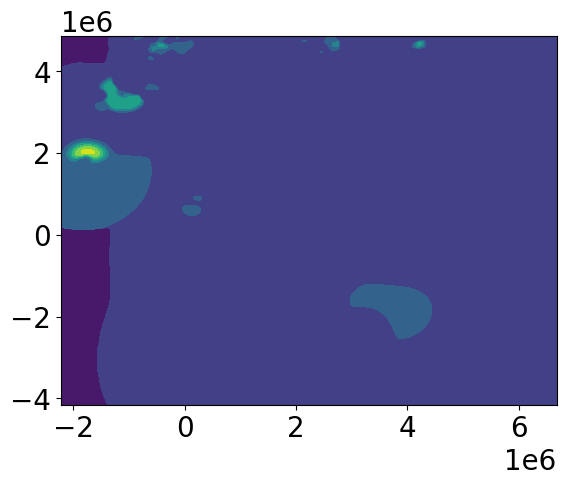

In [386]:
# see where the single distributions are placed
p = plt.contourf(X, Y, Z)
plt.show()

In [387]:
# get borders of all countries
# download https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip
# from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
countries = gpd.datasets.get_path("naturalearth_lowres")
countries = gpd.read_file(countries)
countries = countries.to_crs(epsg=3857)
countries = countries[countries.name != "Antarctica"]
# TODO so far does not work as in final map the raster is not applied to the whole region
# countries = countries[countries.geometry.within(polygon.geometry[0])]
country_shapes = countries.geometry

/tmp/ipykernel_12099/2114002541.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.datasets.get_path("naturalearth_lowres")


In [388]:
# limit heatmap to landmass by asigning inf/ high value to sea
with rasterio.open(map_path) as heatmap:
    out_image, out_transform = rasterio.mask.mask(heatmap, country_shapes, crop=True, filled=False)
    out_meta = heatmap.meta

# grey out countries with no hitchhiking spots
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(map_path, "w", **out_meta) as destination:
    destination.write(out_image)


In [389]:
# select the sice of (important/ populated) cities to show on the map

# CITY_MAX = 100000

# cities = pd.read_csv("../data/worldcities.csv")
# cities.population = cities.population.replace("", np.nan)
# cities = cities.dropna()
# cities.population = cities.population.astype(int)
# cities = cities[cities.population > CITY_MAX]

# geometry = cities.apply(lambda x: Point(x.lng, x.lat), axis=1)
# cities = GeoDataFrame(cities, crs=CRS.from_epsg(4326), geometry=geometry)
# cities = cities.to_crs(epsg=3857)
# cities = cities[cities.geometry.within(polygon.geometry[0])]

In [390]:
# TODO takes more time than expected

# use a pre-compiled list of important cities
# download https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_populated_places.zip
# from https://www.naturalearthdata.com/downloads/10m-cultural-vectors/
# cities = gpd.read_file("cities/ne_10m_populated_places.shp", bbox=polygon.geometry[0]) should work but does not
if CITIES:
    cities = gpd.read_file("cities/ne_10m_populated_places.shp") # takes most time
    cities = cities.to_crs(epsg=3857)
    cities = cities[cities.geometry.within(polygon.geometry[0])]

# use a pre-compiles list of important roads
# download https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_roads.zip
# from https://www.naturalearthdata.com/downloads/10m-cultural-vectors/
if ROADS:
    roads = gpd.read_file("roads/ne_10m_roads.shp")
    roads = roads.to_crs(epsg=3857)
    roads = roads[roads.geometry.within(polygon.geometry[0])]

In [391]:
# define the heatmap color scale

# TODO smoother spectrum instead of buckets
buckets = [
    'grey', # not enough data
    '#008200', # dark green
    '#00c800', # light green
    'green', # green
    '#c8ff00', # light yellow
    '#ffff00', # yellow
    '#ffc800', # light orange
    '#ff8200', # dark orange
    'red', # red
    '#c80000', # dark red
    '#820000', # wine red
    'blue', # not necessary to color
    ]

cmap = colors.ListedColormap(buckets)

max_wait = all_points.wait.max() + 0.1 # to get at least this value as maximum for the colored buckets
num_scale_colors = len(buckets) - 2 # because of upper and lower bucket
# build log scale starting at 0 and ending at max wait
base = (max_wait + 1) ** (1/num_scale_colors)

def log_scale(x):
    return base ** x - 1

# -0.1 and not using the same ints fixes numerical instabilities (some areas having a checkerboard pattern)
# TODO rounding might solve this as well
boundaries = [-1, -0.1] + [log_scale(i) for i in range(1, num_scale_colors+1)] + [max_wait + 10]

norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

# plot the heatmap
raster = rasterio.open(map_path)
fig, ax = plt.subplots(figsize=(100, 100))
rasterio.plot.show(raster, ax=ax, cmap=cmap, norm=norm)
countries.plot(ax=ax, facecolor='none', edgecolor='black')
if CITIES: cities.plot(ax=ax, markersize=1, color='black')
if ROADS: roads.plot(ax=ax, markersize=1, color='black')

all_points.plot(ax=ax, markersize=10, color='red')

fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
plt.savefig(f"{here}/heatchmap/map/map_{region}_{K}.png", bbox_inches='tight')

# extra


In [392]:
# # 75 km = 1 degree at 48 lat

# cut_line = 125

# fig = plt.figure(figsize=(20, 2))
# ax = fig.add_subplot(111)
# ax.plot(Z[cut_line])
# plt.plot()

# # TODO check fwhm -> have to set it to 70km to make it look like on website